## Importação das bibliotecas e base de dados

In [1]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
xray_directory = 'data\Dataset'

In [7]:
os.listdir(xray_directory)

['0', '1', '2', '3']

In [8]:
# Instanciando objeto de ImageDataGenerator para acessar as imagens e aplicando rescale para normalizar os valores dos pixels

image_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# Buscando as imagens de treino no diretório

# batch_size = quantidade de imagens por batch,
# directory = diretório das imagens,
# shuffle = True para embaralhar as imagens,
# target_size = definição do tamanho das imagens,
# class_mode = 'categorical' para classificação multiclasse,
# subset = 'training' indicando que as imagens são de treino

train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [10]:
133 * 4

532

In [11]:
532 / 40

13.3

In [12]:
train_images, train_labels = next(train_generator)

In [13]:
# 40 - quantidade de imagens por batch
# 256 - altura das imagens
# 256 - largura das imagens
# 3 - quantidade de canais de cores (RGB)

train_images.shape

(40, 256, 256, 3)

In [14]:
train_labels

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]],

In [15]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

## Visualização dos dados

In [16]:
np.arange(0, 36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [17]:
np.argmax(train_labels[0])

2

In [19]:
labels_names[2]

'Pneunomia viral'

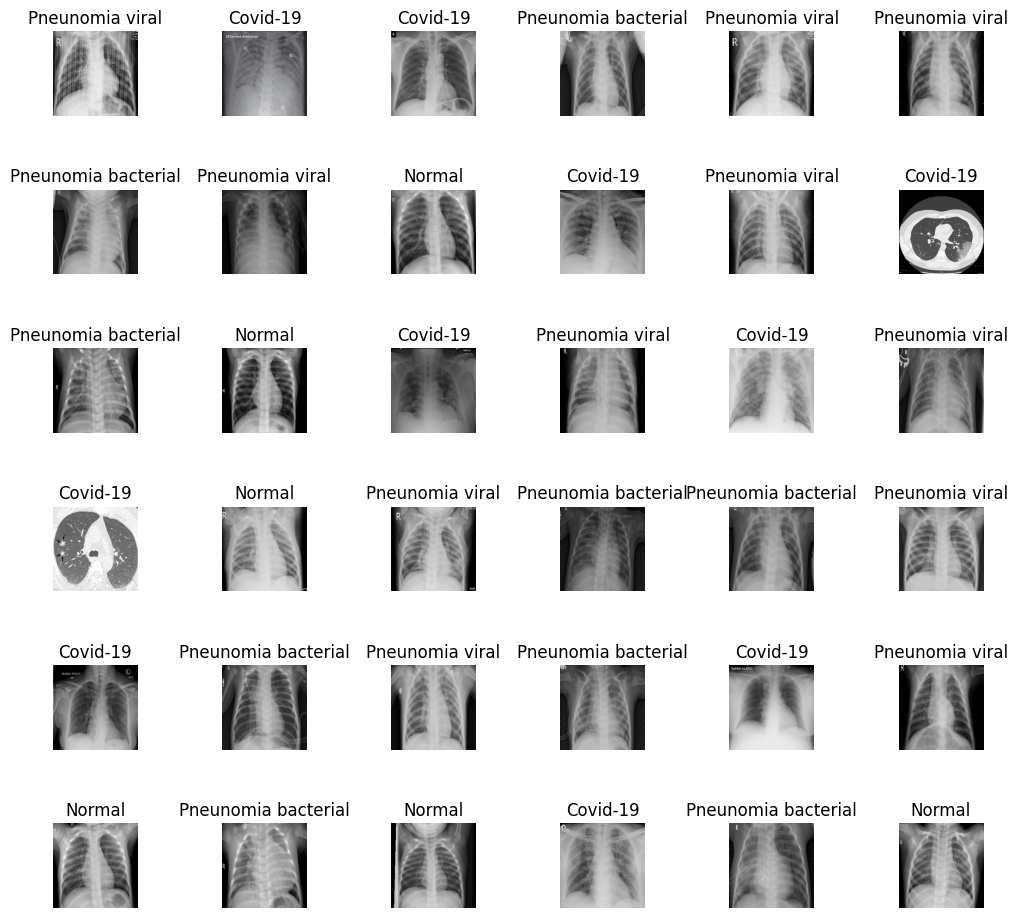

In [21]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=1.0)

## Carregamento da rede neural com pesos pré-treinados

In [22]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [23]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
len(base_model.layers)

175

In [25]:
# Congelando as últimas camadas do modelo. 
# Permite fazer um treinamento mais rápido, mas isso pode ter um impacto no desempenho do algoritmo.
# Avaliar a acurácia do modelo com as camadas congeladas e sem as camadas congeladas.

for layer in base_model.layers[:-10]:
    layer.trainable = False

## Construção e treinamento do modelo de deep learning

In [30]:
# A variavel head_model é a parte do modelo que será treinada e esta ligada ao modelo base.
# AveragePooling2D - Camada de pooling que calcula a média dos valores dos pixels.
# Flatten - Transforma a matriz de pixels em um vetor.
# Dense - Camada densa de 256 neurônios.
# Dropout - Regularização para evitar overfitting.
# Dense - Camada densa de 256 neurônios.
# Dropout - Regularização para evitar overfitting.
# Dense - Camada densa de 4 neurônios com função de ativação softmax.


head_model = base_model.output
head_model = AveragePooling2D(pool_size=(2, 2))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [31]:
# Criando o modelo final

# inputs = camada de entrada do modelo
# outputs = camada de saída do modelo

model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
#model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              #metrics = ['accuracy'])

In [33]:
# Compilando o modelo

# categorical_crossentropy - Função de perda para classificação multiclasse
# RMSprop - Otimizador
# learning_rate - Taxa de aprendizado
# metrics - Métrica de avaliação do modelo

model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4),
              metrics = ['accuracy'])

In [35]:
# Salvando o modelo com a melhor acurácia

checkpointer = ModelCheckpoint(filepath='weights.keras', save_best_only=True)

In [36]:
# Redefunindo o gerador de imagens para o treinamento, pois o anterior foi utilizado para visualização das imagens.

train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [38]:
# Treinando o modelo

# train_generator - gerador de imagens de treino
# epochs - quantidade de épocas
# callbacks - lista de callbacks

# history = model.fit_generator(train_generator, epochs = 25, callbacks=[checkpointer])
history = model.fit(train_generator, epochs = 25, callbacks=[checkpointer])

Epoch 1/25


c:\Users\diogo\OneDrive\Área de Trabalho\DEV\respiratory-disease-prediction\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.2789 - loss: 1.9345
Epoch 2/25


c:\Users\diogo\OneDrive\Área de Trabalho\DEV\respiratory-disease-prediction\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.5147 - loss: 1.1276
Epoch 3/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - accuracy: 0.5635 - loss: 0.9684
Epoch 4/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.6738 - loss: 0.8771
Epoch 5/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - accuracy: 0.6911 - loss: 0.8420
Epoch 6/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 25s 190ms/step - accuracy: 0.7089 - loss: 0.6905
Epoch 7/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step - accuracy: 0.7332 - loss: 0.6527
Epoch 8/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 192ms/step - accuracy: 0.8080 - loss: 0.5646
Epoch 9/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.8281 - loss: 0.5540
Epoch 10/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.8314 - loss: 0.4736
Epoch 11/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.8191 - loss: 0.5092
Epoch 12/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 25s 189ms/step - accuracy: 0.8019 - loss: 0.5514
Epoch 13/25
133/133 ━━━━━━━━━

## Avaliação da rede neural

In [39]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

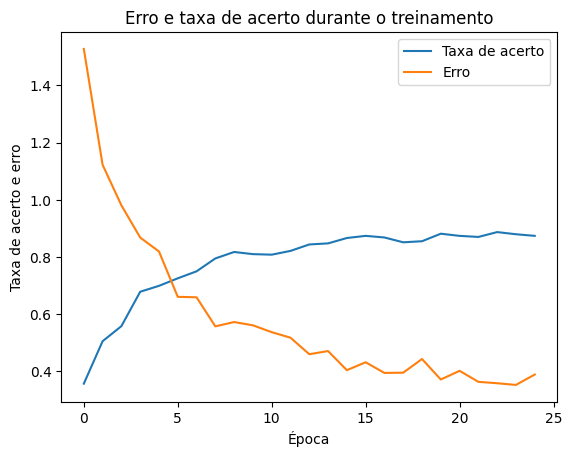

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [41]:
test_directory = 'data\Test'

In [42]:
os.listdir(test_directory)

['0', '1', '2', '3']

In [43]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [45]:
evaluate = model.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7250 - loss: 1.6305


In [46]:
evaluate

[1.6305360794067383, 0.7250000238418579]

In [47]:
len(os.listdir(test_directory))

4

In [48]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━

In [49]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 0, 3, 1, 1, 3, 0, 3, 3, 0, 3, 0, 3, 3, 3, 3]


In [50]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [52]:
accuracy_score(original, prediction)

0.725

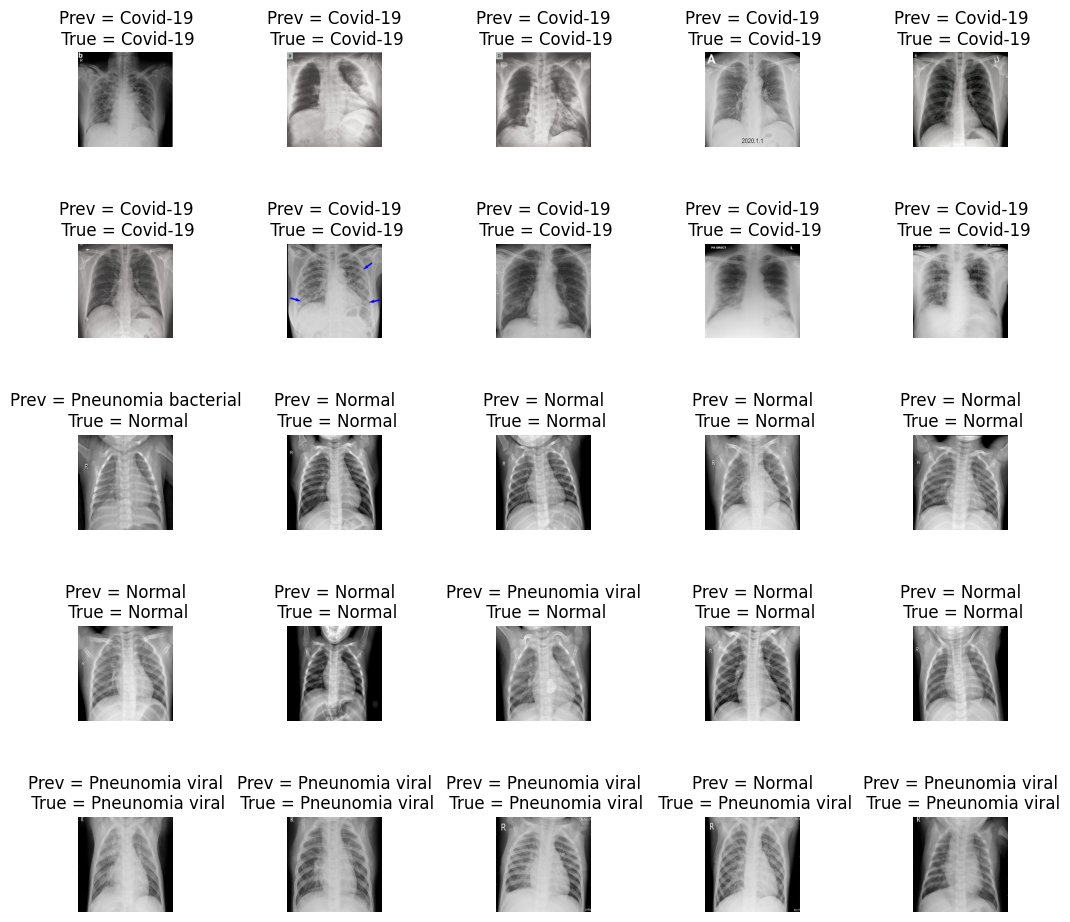

In [64]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title(f'Prev = {labels_names[prediction[i]]}\n True = {labels_names[original[i]]}')
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [57]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

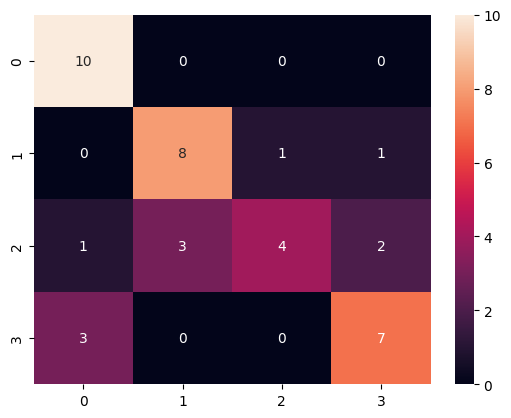

In [58]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [59]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.73      0.80      0.76        10
           2       0.80      0.40      0.53        10
           3       0.70      0.70      0.70        10

    accuracy                           0.72        40
   macro avg       0.74      0.73      0.71        40
weighted avg       0.74      0.72      0.71        40



## Classificação de somente uma imagem

In [ ]:
from keras.models import load_model
model_loaded = load_model('weights.keras')

In [ ]:
model_loaded.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
4 * 4 * 2048

32768

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Cursos - recursos/Ciência de Dados para Empresas e Negócios/Departamento médico/Test/0/radiol.2020200490.fig3.jpeg')

In [ ]:
img, img.shape

(array([[[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        ...,
 
        [[196, 196, 196],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  3,   3,   3],
         [134, 134, 134]],
 
        [[187, 187, 187],
         [  5,   5,   5],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  7,   7,   7],
         [129, 129, 129]],
 
        [[214, 214, 214],
         [ 80,  80,  80],
         [ 87,  87,  87],
         ...,
         [ 80,  80,  80],
  

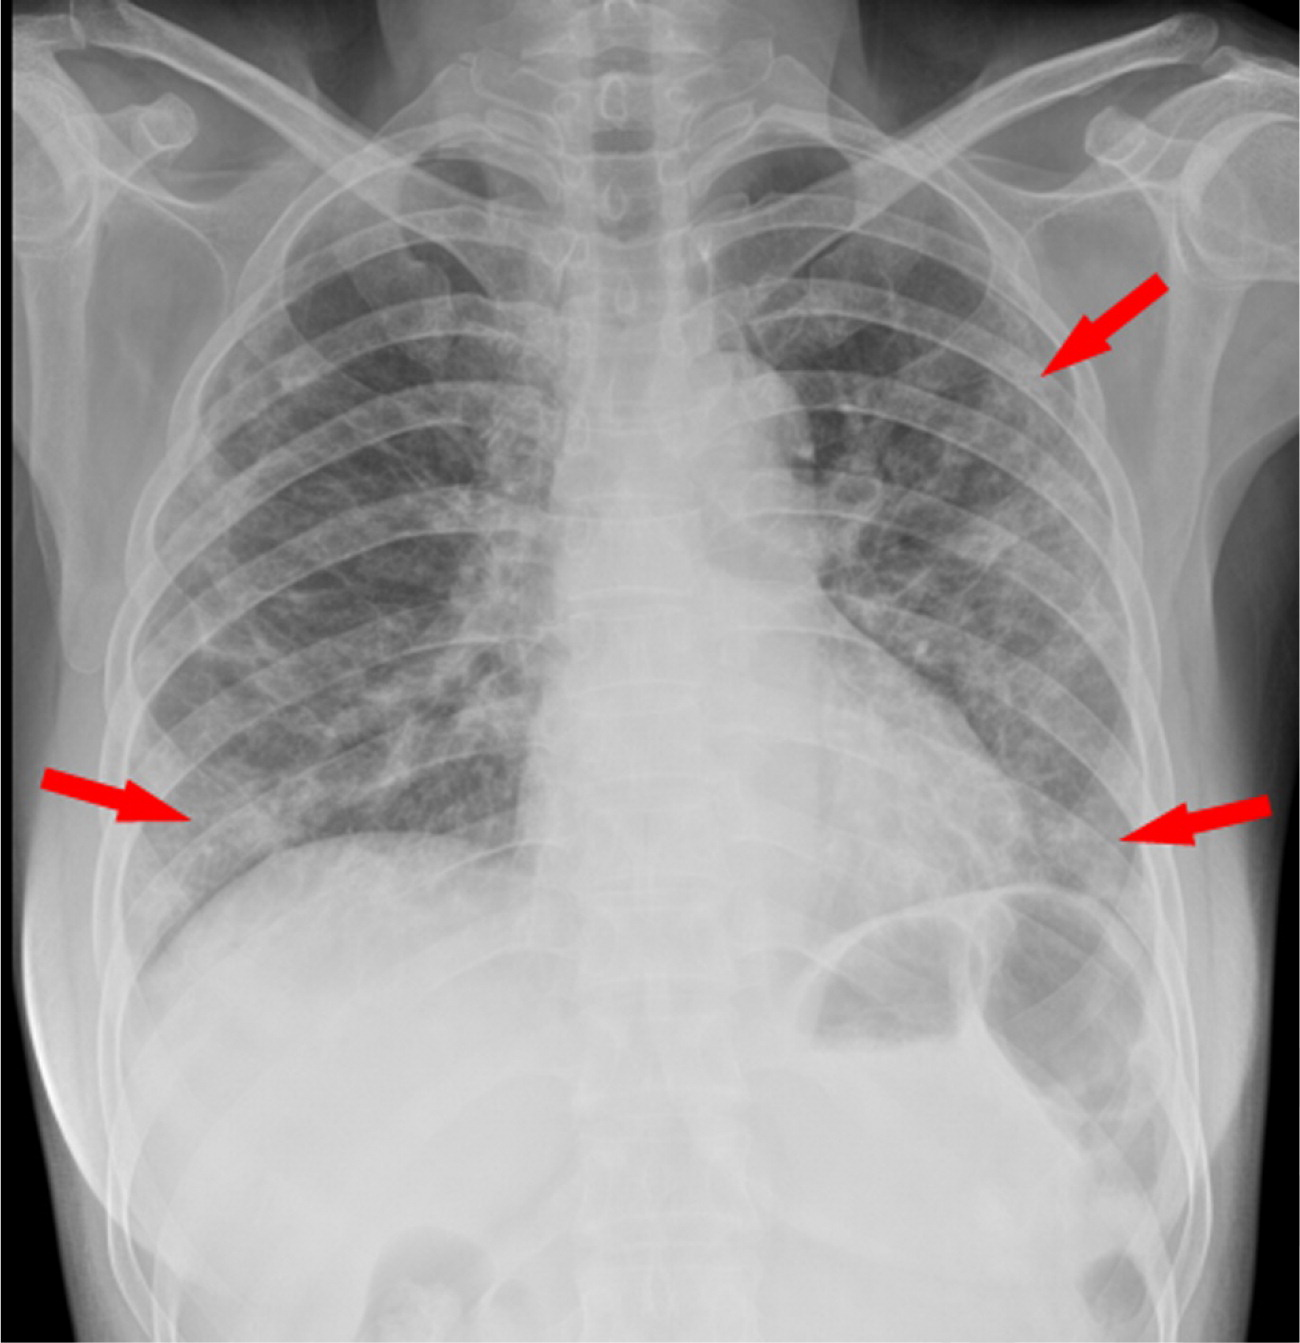

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

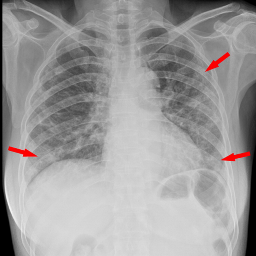

In [ ]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [ ]:
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [ ]:
img.shape

(256, 256, 3)

In [ ]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [ ]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[9.9693167e-01, 1.0865753e-03, 1.4317040e-03, 5.5005174e-04]],
      dtype=float32)>

In [ ]:
predict2 = np.argmax(predict)
predict2

0

In [ ]:
labels_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=0.9969317>)